This is the last article of the blog series for Object Detection with R-CNN.

If you are reading this blog, congratulations for getting this far. 
Now you are ready to experiment the performance of your RCNN classifier.
I will use my own image to see whether the classifier can detect my face.




### Reference: "Object Detection with R-CNN" series in my blog
- [Part 1: Object Detection with Pascal VOC2012 - data preparation and understanding](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_data_preparation_and_understanding.html)


- [Part 2: Object Detection with Pascal VOC2012 - R-CNN overview](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_RCNN_overview.html)


- [Part 3: Object Detection with Pascal VOC2012 - Selective Search](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_selective_search.html)
    - [Implement Local Binary Pattern Descriptor from scratch](https://fairyonice.github.io/implement-lbp-from%20scratch.html)
    
    
- [Part 4: Object Detection with Pascal VOC2012 - CNN feature extraction](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_cnn_feature_extraction.html)


- [Part 5: Object Detection with Pascal VOC2012 - Inference with your own image!](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_inference.html)


### Reference: "Object Detection with R-CNN" series in my Github
- [My Github repository](https://github.com/FairyOnIce/ObjectDetectionRCNN)

### Read in an image
Here, I read-in my picture taken in gloomy San Fransisco.
Let's see whether the RCNN can find me (and possibly the person behind!)
The images are saved in image folder under the current working directory.
This image can be downloaded at [example_image_easy.JPG](https://github.com/FairyOnIce/ObjectDetectionRCNN/blob/master/image/example_image_easy.JPG)


/Users/yumikondo/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


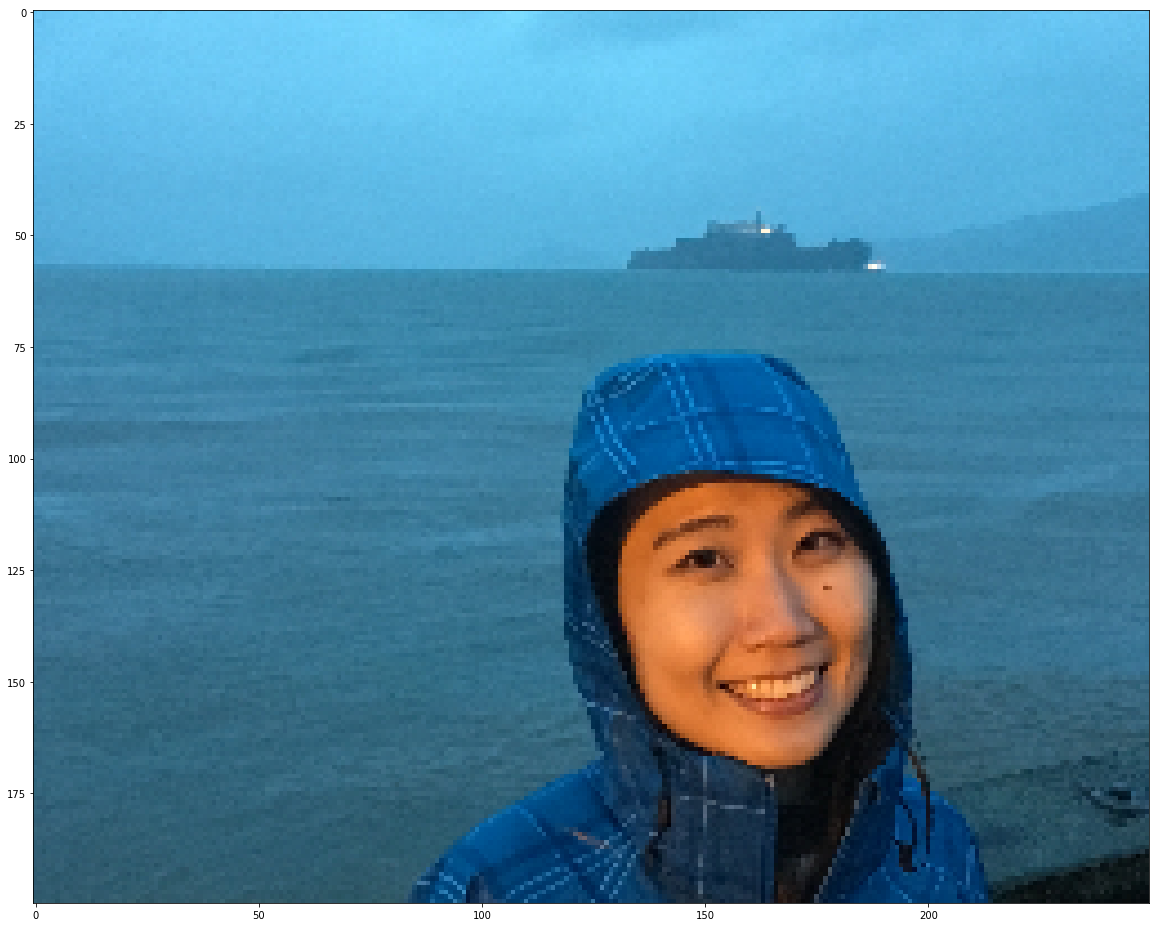

In [1]:
import matplotlib.pyplot as plt
import imageio, os 
import skimage.transform
import numpy as np

dir_image = "image"
img = imageio.imread(os.path.join(dir_image,"example_image_easy.JPG"))
## resize the image because the original image is a bit too large and takes lots of time for computation
# I used this resizing hack to train the classifier and also to extract candidate regions
newsize = (200,250)
img = skimage.transform.resize(img,newsize)
const = 4
plt.figure(figsize=(5*const,6*const))
plt.imshow(img)
plt.show()

## Get region proposals for this image
The codes of selective search is discussed in - [Part 3: Object Detection with Pascal VOC2012 - Selective Search](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_selective_search.html).
And its functions are saved at [my github](https://github.com/FairyOnIce/ObjectDetectionRCNN/blob/master/selective_search.py).

In [2]:
import selective_search as ss
regions = ss.get_region_proposal(img,min_size=50)
print("N candidate regions ={}".format(len(regions)))
print("_"*10)
print("print the first 10 regions")
for r in regions[:10]:
    print(r)
print("_"*10)
print("print the last 10 regions")    
for r in regions[-10:]:
    print(r)

N candidate regions =528
print the first 10 regions and the last 10 regions
{'rect': (0, 0, 27, 15), 'size': 195, 'labels': [0.0]}
{'rect': (8, 0, 28, 9), 'size': 108, 'labels': [1.0]}
{'rect': (28, 0, 25, 8), 'size': 135, 'labels': [2.0]}
{'rect': (45, 0, 21, 4), 'size': 93, 'labels': [3.0]}
{'rect': (63, 0, 35, 16), 'size': 209, 'labels': [4.0]}
{'rect': (76, 0, 13, 10), 'size': 78, 'labels': [5.0]}
{'rect': (84, 0, 29, 10), 'size': 213, 'labels': [6.0]}
{'rect': (95, 0, 39, 22), 'size': 333, 'labels': [7.0]}
{'rect': (110, 0, 24, 10), 'size': 148, 'labels': [8.0]}
{'rect': (124, 0, 24, 6), 'size': 145, 'labels': [9.0]}
{'rect': (85, 104, 127, 95), 'size': 5040, 'labels': [241.0, 260.0, 233.0, 265.0, 248.0, 250.0, 234.0, 245.0, 223.0, 175.0, 160.0, 237.0, 153.0, 251.0, 262.0, 242.0, 243.0, 189.0]}
{'rect': (85, 78, 127, 121), 'size': 6699, 'labels': [241.0, 260.0, 233.0, 265.0, 248.0, 250.0, 234.0, 245.0, 223.0, 175.0, 160.0, 237.0, 153.0, 251.0, 262.0, 242.0, 243.0, 189.0, 117.0, 12

## Visualize all the candidate regions
The following codes simply visualize all the candidate regions extracted from the selective search

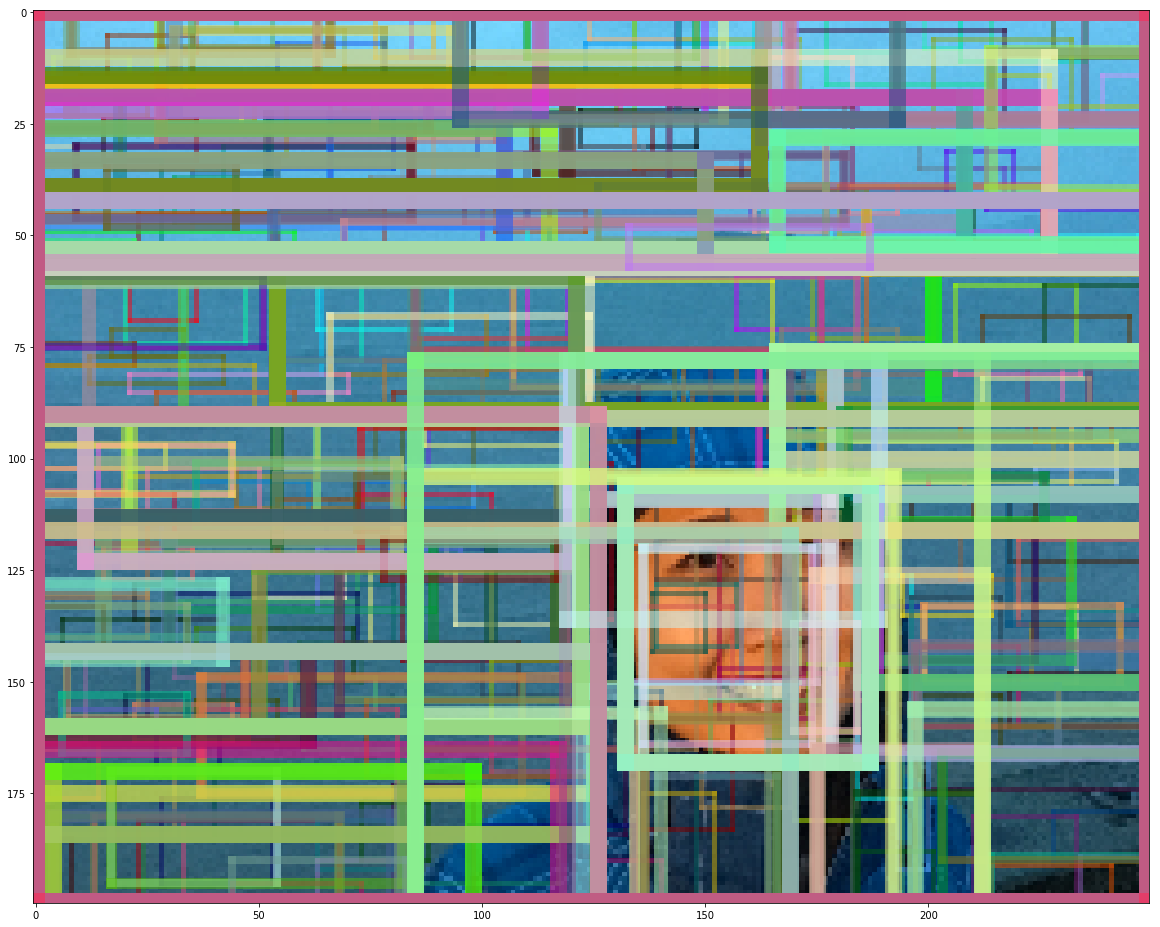

In [3]:

import seaborn as sns
def plt_rectangle(plt,label,x1,y1,x2,y2,color = "yellow", alpha=0.5):
    linewidth = 3
    if type(label) == list:
        linewidth = len(label)*3 + 2
        label = ""
        
    plt.text(x1,y1,label,fontsize=20,backgroundcolor=color,alpha=alpha)
    plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color, alpha=alpha)
    
    
plt.figure(figsize=(20,20))    
plt.imshow(img)
for item, color in zip(regions,sns.xkcd_rgb.values()):
    x1, y1, width, height = item["rect"]
    label = item["labels"][:5]
    plt_rectangle(plt,label,
                  x1,
                  y1,
                  x2 = x1 + width,
                  y2 = y1 + height, 
                  color= color)
plt.show()

## Warp the candidate regions

In [4]:
import numpy as np 

def warp_candidate_regions(img,regions):
    ## for each candidate region, 
    ## warp the image and extract features 
    newsize_cnn = (224, 224)
    X = []
    for i, r in enumerate(regions):
        origx , origy , width, height = r["rect"]
        candidate_region = img[origy:origy + height,
                               origx:origx + width]
        img_resize = skimage.transform.resize(candidate_region,newsize_cnn)
        X.append(img_resize)

    X = np.array(X)
    print(X.shape)
    return(X)
X = warp_candidate_regions(img,regions)

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(528, 224, 224, 3)


## Extract CNN features
In previous blog [Part 4: Object Detection with Pascal VOC2012 - CNN feature extraction](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_cnn_feature_extraction.html), 
I used VGGNet to extract the pre-trained CNN features. 
So for inference, I will once again use the same CNN features.

Here are some explanations quoted from my previous blog post.

<p style="margin-left: 40px;">

For each region proposal, [R-CNN](https://arxiv.org/pdf/1311.2524.pdf) proposes to extract 4096-dimensional feature vector from each region proposal from [Alex-Net](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), the winner of the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012. 


</p>
<blockquote>
The ImageNet project is a large visual database designed for use in visual object recognition software research. The ImageNet project runs an annual software contest, the ImageNet Large Scale Visual Recognition Challenge. 
</blockquote>

<p style="margin-left: 40px;">
Since the R-CNN paper was published in 2012, there were quite some improvement in the ILSVRC, and Alex-Net is somewhat obsolete. In this blog post, I will rather use VGGNet to extract features. VGGNet (2014) is the runner-up at the ILSVRC 2014 competition is dubbed VGGNet by the community and was developed by Simonyan and Zisserman.
VGGNet consists of 16 convolutional layers and is very appealing because of its very uniform architecture. 
</p>

<p style="margin-left: 40px;">
**VGGNet**
</p>
<p style="margin-left: 40px;">
<img src="https://farm5.staticflickr.com/4900/45295225774_60a2171338_b.jpg" width="524" height="618" alt="Screen Shot 2018-11-23 at 2.43.29 PM">
Cited from [VGG in TensorFlow](https://www.cs.toronto.edu/~frossard/post/vgg16/). 

Similar to AlexNet, VGGNet uses only 3x3 convolutions. However, VGGNet has a lot more filters. See the model arthiceture above. It contains 16 layers with trainable weights. It is currently the most preferred choice in the community for extracting features from images. The weight configuration of the VGGNet is publicly available, including in [Keras](https://keras.io/applications/#vgg16), and has been used in many other applications and challenges as a baseline feature extractor.


So let's get started with extracting the VGGNet.
</p>

In [5]:
from keras.applications import VGG16
modelvgg16 = VGG16(include_top=True,weights='imagenet')
modelvgg16.summary()

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
blo

As during the training, we need to clip the last two layers of the VGGnet.
Here is the discussion quoted from my previous blog [Part 4: Object Detection with Pascal VOC2012 - CNN feature extraction](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_cnn_feature_extraction.html).

<p style="margin-left: 40px;">
VGGNet is developed for ILSVRC so its network is designed to classify images into 1,000 different classes. 
As I am not using VGGNet for the sake of the classification but I just need it for extracting features, I will remove the last and the second the last layer from the network.
</p>
<p style="margin-left: 40px;">
In "Performance layer-by-layer without fine-turning" section of R-CNN paper, there is some discussion on which layer to use in Alex-Net to extract CNN features. 
They mentioned that removing the final two fully connected layers and use only the pool layer as CNN features for object detection can yield as good performance. They say:
</p>
<blockquote>
Much of the CNN's representational power comes from its convolutional layers, rather than from the much larger densely connected layers.
</blockquote>
<p style="margin-left: 40px;">
Nevertheless, I will remove the last one fully connected layer and use the first fully connected layer output as the CNN Features. 
The next codes remove the last two layers.
</p>

In [ ]:
from keras import models
modelvgg = models.Model(inputs  = modelvgg16.inputs, 
                        outputs = modelvgg16.layers[-3].output)
## show the deep learning model
modelvgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Finally Extract pretrained CNN features.
This step needs some time.

In [ ]:
import time
start   = time.time()
feature = modelvgg.predict(X)
end     = time.time()
print("TIME TOOK: {:5.4f}MIN".format((end-start)/60.0))
feature.shape

## Prediciton with ANN classifier to find a candidate region with a person object
The classifier trained in the previous blog [Part 4: Object Detection with Pascal VOC2012 - CNN feature extraction](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_cnn_feature_extraction.html) is saved at output folder under the current directory.

In [ ]:
from keras.models import load_model

dir_result = "output"
classifier = load_model(os.path.join(dir_result,"classifier.h5"))
classifier.summary()
y_pred = classifier.predict(feature)

Finally plot the candidate regions that have the highest/lowest likelihood of containining a person objects.

In [ ]:
def plot_selected_regions_with_estimated_prob(y_pred,
                                              method="highest",
                                              upto=5):
    ## increasing order
    irows = np.argsort(y_pred[:,0])
    if method == "highest":
        irows = irows[::-1]
    count = 1
    const = 4
    fig = plt.figure(figsize=(upto*const,const))
    fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                        left=0,right=1,bottom=0, top=1)
    for irow in irows:
        prob = y_pred[irow,0]
        r    = regions[irow]
        origx , origy , width, height = r["rect"]
        
        ax = fig.add_subplot(1,upto,count)
        ax.imshow(img)
        ax.axis("off")
        plt_rectangle(ax,label="",
                      x1=origx,
                      y1=origy,
                      x2=origx + width,
                      y2=origy+height,color = "yellow", alpha=0.5)
        
        #candidate_region = img[origy:origy + height,
        #                      origx:origx + width]       
        #ax.imshow(candidate_region)
        ax.set_title("Prob={:4.3f}".format(prob))
        count += 1
        if count > upto:
            break
    plt.show()
print("The most likely candidate regions")    
plot_selected_regions_with_estimated_prob(y_pred,method="highest",upto=5)
print("The least likely candidate regions")   
plot_selected_regions_with_estimated_prob(y_pred,method="lowest",upto=5)

## More examples!
Ok. The results seem very reasonable. The highest probability is assigned to the candidate region that captuers my entire facein the most compact way. On the other hand, the lowest probability is assigned to the region with the homogeneous ocean region.

But this picture may be a bit too easy for a person detection as it only contains a single person and the background color is very homogeneous. Let's try more difficult images.

In [ ]:
dir_image = "image"
for myid in range(1,5):
    img = imageio.imread(os.path.join(dir_image,"example_id{}.JPG".format(myid)))
    img = skimage.transform.resize(img,newsize)

    regions = ss.get_region_proposal(img,min_size=50)
    X = warp_candidate_regions(img,regions)
    feature = modelvgg.predict(X)
    y_pred = classifier.predict(feature)

    plot_selected_regions_with_estimated_prob(y_pred,
                                              method="highest",
                                              upto=5)